In [1]:
from tespy.networks import Network
from tespy.components import (Sink, Source, Valve, SimpleHeatExchanger, Compressor, CycleCloser)
from tespy.connections import Connection, Bus
from tespy.tools import ExergyAnalysis
from CoolProp.CoolProp import PropsSI as cpsi

#fluids
wf = 'R407c'
fld_wf = {wf:1}

#network
heatpump = Network(T_unit = 'C', p_unit = 'bar', h_unit = 'kJ / kg', m_unit = 'kg / s')

#components
src_wf = Source('working-fluid-source')
snk_wf = Sink('working-fluid-sink')
cmp_th = Valve('throttle')
cmp_ev = SimpleHeatExchanger('evaporator')
cmp_cp = Compressor('compressor')
cmp_co = SimpleHeatExchanger('condensor')
cmp_cc = CycleCloser('cycle-closer')

#connection

c03   = Connection(cmp_cc, 'out1', cmp_th, 'in1', label = '03')
c04   = Connection(cmp_th, 'out1', cmp_ev, 'in1', label = '04')
c01   = Connection(cmp_ev, 'out1', cmp_cp, 'in1', label = '01')
c02   = Connection(cmp_cp, 'out1', cmp_co, 'in1', label = '02')
c02cc = Connection(cmp_co, 'out1', cmp_cc, 'in1', label = '02cc')

heatpump.add_conns(c01, c02, c02cc, c03, c04)

#parameters

#components
cmp_ev.set_attr(pr = 1)
cmp_cp.set_attr(eta_s = 0.75)
cmp_co.set_attr(Q = -20e3, pr = 1)

#connection

h_li = cpsi('H', 'Q', 0, 'T', 40 + 273.15, wf)/1e3
c02cc.set_attr(h = h_li, fluid = fld_wf)

T_sat = cpsi('T', 'Q', 1, 'P', 5*1e5, wf) - 273.15
c04.set_attr(p = 5)

h_sh = cpsi('H', 'P', 5*1e5, 'T', T_sat + 2 + 273.15, wf)/1e3
c01.set_attr(h = h_sh)

c02.set_attr(p = 20)

#power and heat busses
motor = Bus('motor')
motor.add_comps({'comp' : cmp_cp, 'char' : 0.95, 'base' : 'bus'})

heating = Bus('heating heat')
heating.add_comps({'comp' : cmp_co, 'base' : 'bus'})

heatpump.add_busses(motor,  heating)

#solve
heatpump.solve(mode='design')
heatpump.print_results()

#print COP
print('COP:', -heating.P.val/motor.P.val)

#exergy analysis
ean = ExergyAnalysis(network=heatpump, E_F = [motor], E_P = [heating])
ean.analyse(1.013, 25)
ean.print_results()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        | 3.62e-01   | 2.45e+06   | 3.23e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.16e+05   | 10 %       | 1.76e+00   | 0.00e+00   | 8.91e+04   | 0.00e+00   | 0.00e+00   
 3     | 1.57e+05   | 8 %        | 7.93e-01   | 5.82e-11   | 1.49e-11   | 0.00e+00   | 0.00e+00   
 4     | 1.50e-11   | 100 %      | 8.47e-18   | 0.00e+00   | 1.94e-11   | 0.00e+00   | 0.00e+00   
 5     | 6.00e-11   | 100 %      | 7.64e-18   | 5.82e-11   | 1.49e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.01 s, Iterations per second: 487.05

##### RESULTS (SimpleHeatExchanger) #####
+------------+-----------+----------+----------+-----+-----+------+---------+------+--------+
|            |         Q |       pr |     zeta |   D |   L |   ks |   ks_HW |   kA |   Tamb 

Text(21.92682671440972, 0.5, 'Pressure [bar]')

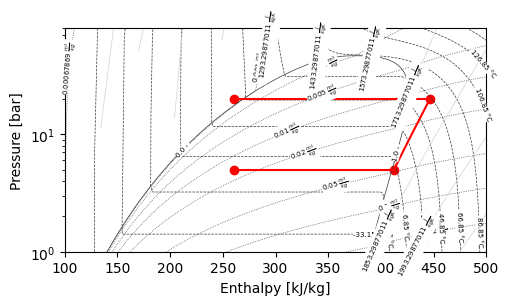

In [7]:
# log p h diagram

import matplotlib.pyplot as plt
from fluprodia import FluidPropertyDiagram

result_dict = {}
result_dict.update({cmp_ev.label : cmp_ev.get_plotting_data()[1]})
result_dict.update({cmp_cp.label : cmp_cp.get_plotting_data()[1]})
result_dict.update({cmp_co.label : cmp_co.get_plotting_data()[1]})
result_dict.update({cmp_th.label : cmp_th.get_plotting_data()[1]})
result_dict.update({cmp_ev.label : cmp_ev.get_plotting_data()[1]})


diagram = FluidPropertyDiagram('R407c')
diagram.set_unit_system(T='°C', p='bar', h='kJ/kg')
diagram.calc_isolines()

fig, ax = plt.subplots(1, figsize=(5, 3))
diagram.draw_isolines(diagram_type = 'logph', fig = fig, ax = ax, x_min=100, x_max=500, y_min=1e0, y_max=8e1)
plt.tight_layout()

for key, data in result_dict.items():
        result_dict[key]['datapoints'] = diagram.calc_individual_isoline(**data)


for key in result_dict.keys():
    datapoints = result_dict[key]['datapoints']
    ax.plot(datapoints['h'],datapoints['p'], color='#ff0000')
    ax.scatter(datapoints['h'][0],datapoints['p'][0], color='#ff0000')

ax.set_xlabel('Enthalpy [kJ/kg]')
ax.set_ylabel('Pressure [bar]')

In [3]:
# Bereitung der Daten für die Sensitivitätsanalyse

import numpy as np

eff_motor = np.linspace(0.1,1,10)
eff_comp = np.linspace(0.1,1,10)
cop_result = [[0 for i in range(len(eff_motor))] for j in range(len(eff_comp))]

for i in range(len(eff_motor)):
    for j in range(len(eff_comp)):
        #fluids
        wf = 'R407c'
        fld_wf = {wf:1}

        #network
        heatpump = Network(T_unit = 'C', p_unit = 'bar', h_unit = 'kJ / kg', m_unit = 'kg / s')

        #components
        src_wf = Source('working-fluid-source')
        snk_wf = Sink('working-fluid-sink')
        cmp_th = Valve('throttle')
        cmp_ev = SimpleHeatExchanger('evaporator')
        cmp_cp = Compressor('compressor')
        cmp_co = SimpleHeatExchanger('condensor')
        cmp_cc = CycleCloser('cycle-closer')

        #connection

        c03   = Connection(cmp_cc, 'out1', cmp_th, 'in1', label = '03')
        c04   = Connection(cmp_th, 'out1', cmp_ev, 'in1', label = '04')
        c01   = Connection(cmp_ev, 'out1', cmp_cp, 'in1', label = '01')
        c02   = Connection(cmp_cp, 'out1', cmp_co, 'in1', label = '02')
        c02cc = Connection(cmp_co, 'out1', cmp_cc, 'in1', label = '02cc')

        heatpump.add_conns(c01, c02, c02cc, c03, c04)

        #parameters

        #components
        cmp_ev.set_attr(pr = 1)
        cmp_cp.set_attr(eta_s = eff_comp[j])
        cmp_co.set_attr(Q = -20e3, pr = 1)

        #connection
        h_li = cpsi('H', 'Q', 0, 'T', 40 + 273.15, wf)/1e3
        c02cc.set_attr(h = h_li, fluid = fld_wf)

        T_sat = cpsi('T', 'Q', 1, 'P', 5*1e5, wf) - 273.15
        c04.set_attr(p = 5)

        h_sh = cpsi('H', 'P', 5*1e5, 'T', T_sat + 2 + 273.15, wf)/1e3
        c01.set_attr(h = h_sh)

        c02.set_attr(p = 20)

        #power and heat busses
        motor = Bus('motor')
        motor.add_comps({'comp' : cmp_cp, 'char' : eff_motor[i], 'base' : 'bus'})

        heating = Bus('heating heat')
        heating.add_comps({'comp' : cmp_co, 'base' : 'bus'})

        heatpump.add_busses(motor,  heating)

        #solve
        heatpump.solve(mode='design')

        #print COP
        cop_result[i][j] = -heating.P.val/motor.P.val   

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.04e+06   | 0 %        | 3.21e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 7.51e+05   | 1 %        | 1.65e+01   | 5.82e-11   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 7.91e+06   | 0 %        | 2.87e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 2.67e+06   | 0 %        | 9.66e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 8.92e+05   | 0 %        | 3.25e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 3.07e+05   | 5 %        | 1.10e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 9.75e+04   | 11 %       | 3.69e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 4.12e+04   | 15 %       | 1.24e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.04e+06   | 0 %        | 4.40e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.38e+05   | 9 %        | 2.49e+00   | 5.82e-11   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 2.45e+05   | 6 %        | 1.22e+00   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 6.26e-11   | 100 %      | 1.01e-16   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.00 s, Iterations per second: inf

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.05e+06   | 0 %        

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %        | 2.33e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 5.51e+05   | 2 %        | 1.20e+01   | 0.00e+00   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 5.71e+06   | 0 %        | 2.07e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 1.93e+06   | 0 %        | 6.98e+00   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 6.43e+05   | 2 %        | 2.35e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 2.24e+05   | 7 %        | 7.91e-01   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 6.96e+04   | 12 %       | 2.66e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 3.23e+04   | 16 %       | 8.97e-02   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        | 3.37e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.17e+05   | 10 %       | 1.99e+00   | 0.00e+00   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 1.96e+05   | 7 %        | 9.78e-01   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 7.28e-12   | 100 %      | 5.16e-18   | 0.00e+00   | 1.04e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.87e-11   | 100 %      | 7.55e-18   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.00 s, Iterations per second: 1107.79

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %    

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %        | 2.55e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 6.00e+05   | 2 %        | 1.31e+01   | 5.82e-11   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 6.25e+06   | 0 %        | 2.27e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 2.11e+06   | 0 %        | 7.63e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 7.04e+05   | 1 %        | 2.57e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 2.44e+05   | 6 %        | 8.65e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 7.63e+04   | 12 %       | 2.91e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 3.44e+04   | 16 %       | 9.80e-02   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        | 3.94e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.29e+05   | 9 %        | 2.27e+00   | 5.82e-11   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 2.24e+05   | 7 %        | 1.11e+00   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 6.26e-11   | 100 %      | 1.01e-16   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.00 s, Iterations per second: inf

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.04e+06   | 0 %        | 3.02e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 7.08e+05   | 1 %        | 1.56e+01   | 0.00e+00   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 7.44e+06   | 0 %        | 2.70e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 2.51e+06   | 0 %        | 9.09e+00   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 8.39e+05   | 0 %        | 3.06e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 2.90e+05   | 5 %        | 1.03e+00   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 9.15e+04   | 11 %       | 3.47e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 3.93e+04   | 15 %       | 1.17e-01   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.01e+06   | 0 %        | 2.38e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 9.78e+04   | 11 %       | 1.52e+00   | 0.00e+00   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 1.50e+05   | 9 %        | 7.45e-01   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 2.30e-11   | 100 %      | 1.04e-16   | 0.00e+00   | 1.04e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.00 s, Iterations per second: inf

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.04e+06   | 0 %        

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        | 2.61e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 6.14e+05   | 2 %        | 1.34e+01   | 0.00e+00   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 6.41e+06   | 0 %        | 2.32e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 2.16e+06   | 0 %        | 7.83e+00   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 7.22e+05   | 1 %        | 2.64e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 2.50e+05   | 6 %        | 8.87e-01   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 7.83e+04   | 12 %       | 2.99e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 3.50e+04   | 16 %       | 1.01e-01   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        | 3.87e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.27e+05   | 9 %        | 2.24e+00   | 5.82e-11   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 2.20e+05   | 7 %        | 1.10e+00   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 6.26e-11   | 100 %      | 1.01e-16   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.01 s, Iterations per second: 902.19

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %     

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.04e+06   | 0 %        | 3.15e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 7.38e+05   | 1 %        | 1.62e+01   | 0.00e+00   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 7.77e+06   | 0 %        | 2.82e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 2.62e+06   | 0 %        | 9.49e+00   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 8.76e+05   | 0 %        | 3.19e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 3.02e+05   | 5 %        | 1.08e+00   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 9.56e+04   | 11 %       | 3.62e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 4.06e+04   | 15 %       | 1.22e-01   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.04e+06   | 0 %        | 4.43e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.39e+05   | 9 %        | 2.51e+00   | 0.00e+00   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 2.47e+05   | 6 %        | 1.23e+00   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 2.30e-11   | 100 %      | 1.04e-16   | 0.00e+00   | 1.04e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.01 s, Iterations per second: 907.11

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %     

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        | 2.97e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 6.97e+05   | 1 %        | 1.53e+01   | 5.82e-11   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 7.32e+06   | 0 %        | 2.65e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 2.47e+06   | 0 %        | 8.94e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 8.25e+05   | 0 %        | 3.01e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 2.85e+05   | 6 %        | 1.01e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 8.99e+04   | 11 %       | 3.41e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 3.88e+04   | 15 %       | 1.15e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.04e+06   | 0 %        | 4.57e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.42e+05   | 9 %        | 2.57e+00   | 0.00e+00   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 2.53e+05   | 6 %        | 1.26e+00   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 2.30e-11   | 100 %      | 1.04e-16   | 0.00e+00   | 1.04e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.00 s, Iterations per second: inf

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %        | 2.49e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 5.88e+05   | 2 %        | 1.28e+01   | 5.82e-11   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 6.11e+06   | 0 %        | 2.22e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 2.07e+06   | 0 %        | 7.47e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 6.89e+05   | 1 %        | 2.51e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 2.39e+05   | 6 %        | 8.46e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 7.46e+04   | 12 %       | 2.85e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 3.39e+04   | 16 %       | 9.59e-02   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %        | 2.66e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.03e+05   | 10 %       | 1.65e+00   | 5.82e-11   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 1.63e+05   | 8 %        | 8.11e-01   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 6.26e-11   | 100 %      | 1.01e-16   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.00 s, Iterations per second: 1106.09

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.05e+06   | 0 %    

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %        | 2.22e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 5.26e+05   | 3 %        | 1.14e+01   | 0.00e+00   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 5.44e+06   | 0 %        | 1.97e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 1.84e+06   | 0 %        | 6.64e+00   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 6.12e+05   | 2 %        | 2.24e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 2.13e+05   | 7 %        | 7.53e-01   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 6.60e+04   | 13 %       | 2.53e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 3.11e+04   | 16 %       | 8.53e-02   | 0.00e+00   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %        | 3.03e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.10e+05   | 10 %       | 1.83e+00   | 5.82e-11   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 1.81e+05   | 8 %        | 8.99e-01   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 5.87e-11   | 100 %      | 7.55e-18   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.01 s, Iterations per second: 498.69

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %     

The solver does not seem to make any progress, aborting calculation. Residual value is 1.34e+04. This frequently happens, if the solver pushes the fluid properties out of their feasible range.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %        | 2.19e+00   | 2.45e+06   | 7.22e+05   | 0.00e+00   | 0.00e+00   
 2     | 5.18e+05   | 3 %        | 1.12e+01   | 5.82e-11   | 6.40e+05   | 0.00e+00   | 0.00e+00   
 3     | 5.35e+06   | 0 %        | 1.94e+01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 4     | 1.81e+06   | 0 %        | 6.53e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 5     | 6.02e+05   | 2 %        | 2.20e+00   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 6     | 2.10e+05   | 7 %        | 7.40e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 7     | 6.49e+04   | 13 %       | 2.49e-01   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 8     | 3.08e+04   | 16 %       | 8.39e-02   | 5.82e-11   | 1.24e+05   | 0.00e+00   | 0.00e+00   
 9     | 


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.03e+06   | 0 %        | 3.65e-01   | 2.45e+06   | 3.25e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.23e+05   | 10 %       | 2.13e+00   | 0.00e+00   | 9.85e+04   | 0.00e+00   | 0.00e+00   
 3     | 2.10e+05   | 7 %        | 1.05e+00   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
 4     | 2.30e-11   | 100 %      | 1.04e-16   | 0.00e+00   | 1.04e-11   | 0.00e+00   | 0.00e+00   
 5     | 5.88e-11   | 100 %      | 1.06e-17   | 5.82e-11   | 1.52e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.00 s, Iterations per second: inf

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.02e+06   | 0 %        

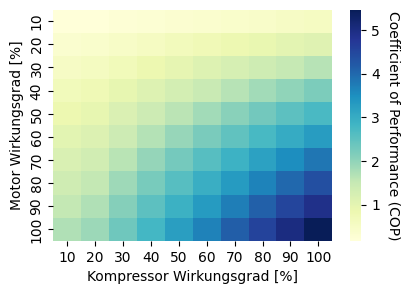

In [4]:
# Plot der Sensitivitäts Heatmap

import seaborn as sns

cop_array = np.array(cop_result)

plt.figure(figsize=(4.5, 3))
heatmap = sns.heatmap(cop_array, annot=False, cmap="YlGnBu",
                      xticklabels=[f"{val*100:.0f}" for val in eff_comp],
                      yticklabels=[f"{val*100:.0f}" for val in eff_motor])

cbar = heatmap.collections[0].colorbar
cbar.set_label('Coefficient of Performance (COP)', rotation=270, labelpad=15)

plt.xlabel('Kompressor Wirkungsgrad [%]')
plt.ylabel('Motor Wirkungsgrad [%]')
plt.show()

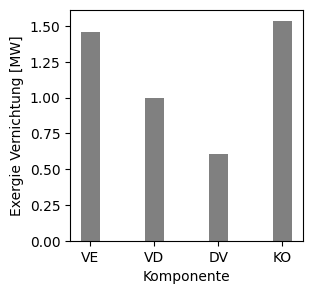

In [5]:
# Exergie Vernichtung Histogramm

component_data = ean.component_data["E_D"]
component_data = component_data.drop(index='cycle-closer')
komponenten_namen = list(component_data.index)
exergie_werte = component_data.values

deutsche_namen = {
    'throttle': 'DV',
    'compressor': 'VD',
    'condensor': 'KO',
    'evaporator': 'VE',
}

plt.figure(figsize=(3, 3))
bar_breite = 0.3  

plt.bar([deutsche_namen[comp] for comp in komponenten_namen],
        exergie_werte/1000, color='grey', width=bar_breite) 

plt.xlabel('Komponente')
plt.ylabel('Exergie Vernichtung [MW]')
plt.show()